In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# displacement charges
dq_trajs = list(np.load(f"{DATA_DIR}/raw_feat/displacement_q_0-178.npy"))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_179-end.npy", allow_pickle=True))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_anton2.npy"))
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8]  # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[
    8
]  # 0.1 ns lag time
# correlation functions
acf = np.load(f"{DATA_DIR}/acf_qp_dq_ds.npy")

# remove trajectory 180 (missing full data)
cv_trajs = [*cv_trajs[:180], *cv_trajs[181:]]
sb_trajs = [*sb_trajs[:180], *sb_trajs[181:]]
sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)
qp_du = [*qp_du[:180], *qp_du[181:]]
weights = [*weights[:180], *weights[181:]]

In [5]:
print(
    cv_arr.shape,
    sb_arr.shape,
    np.concatenate(qp_du).shape,
    np.concatenate(dq_trajs).shape,
)

(4050115, 2) (4050115, 60) (4050115,) (4050115,)


In [6]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [7]:
def mean_std(trajs, ids):
    arr = np.concatenate(trajs)[ids]
    return np.mean(arr), np.std(arr, ddof=1)


down_avg, down_std = mean_std(dq_trajs, down_ids)
up_avg, up_std = mean_std(dq_trajs, up_ids)
print(down_avg, down_std)
print(up_avg, up_std)
print(up_avg - down_avg, np.sqrt(down_std**2 + up_std**2))

-4.173267005463239 0.2344045016775164
-3.287910395167272 0.20684185196073684
0.8853566102959669 0.3126164137233235


In [8]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(~(down_ids | up_ids), traj_inds)

In [9]:
from extq.stop import forward_stop

/scratch/local/jobs/5469169/ipykernel_561117/2629870119.py:32: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


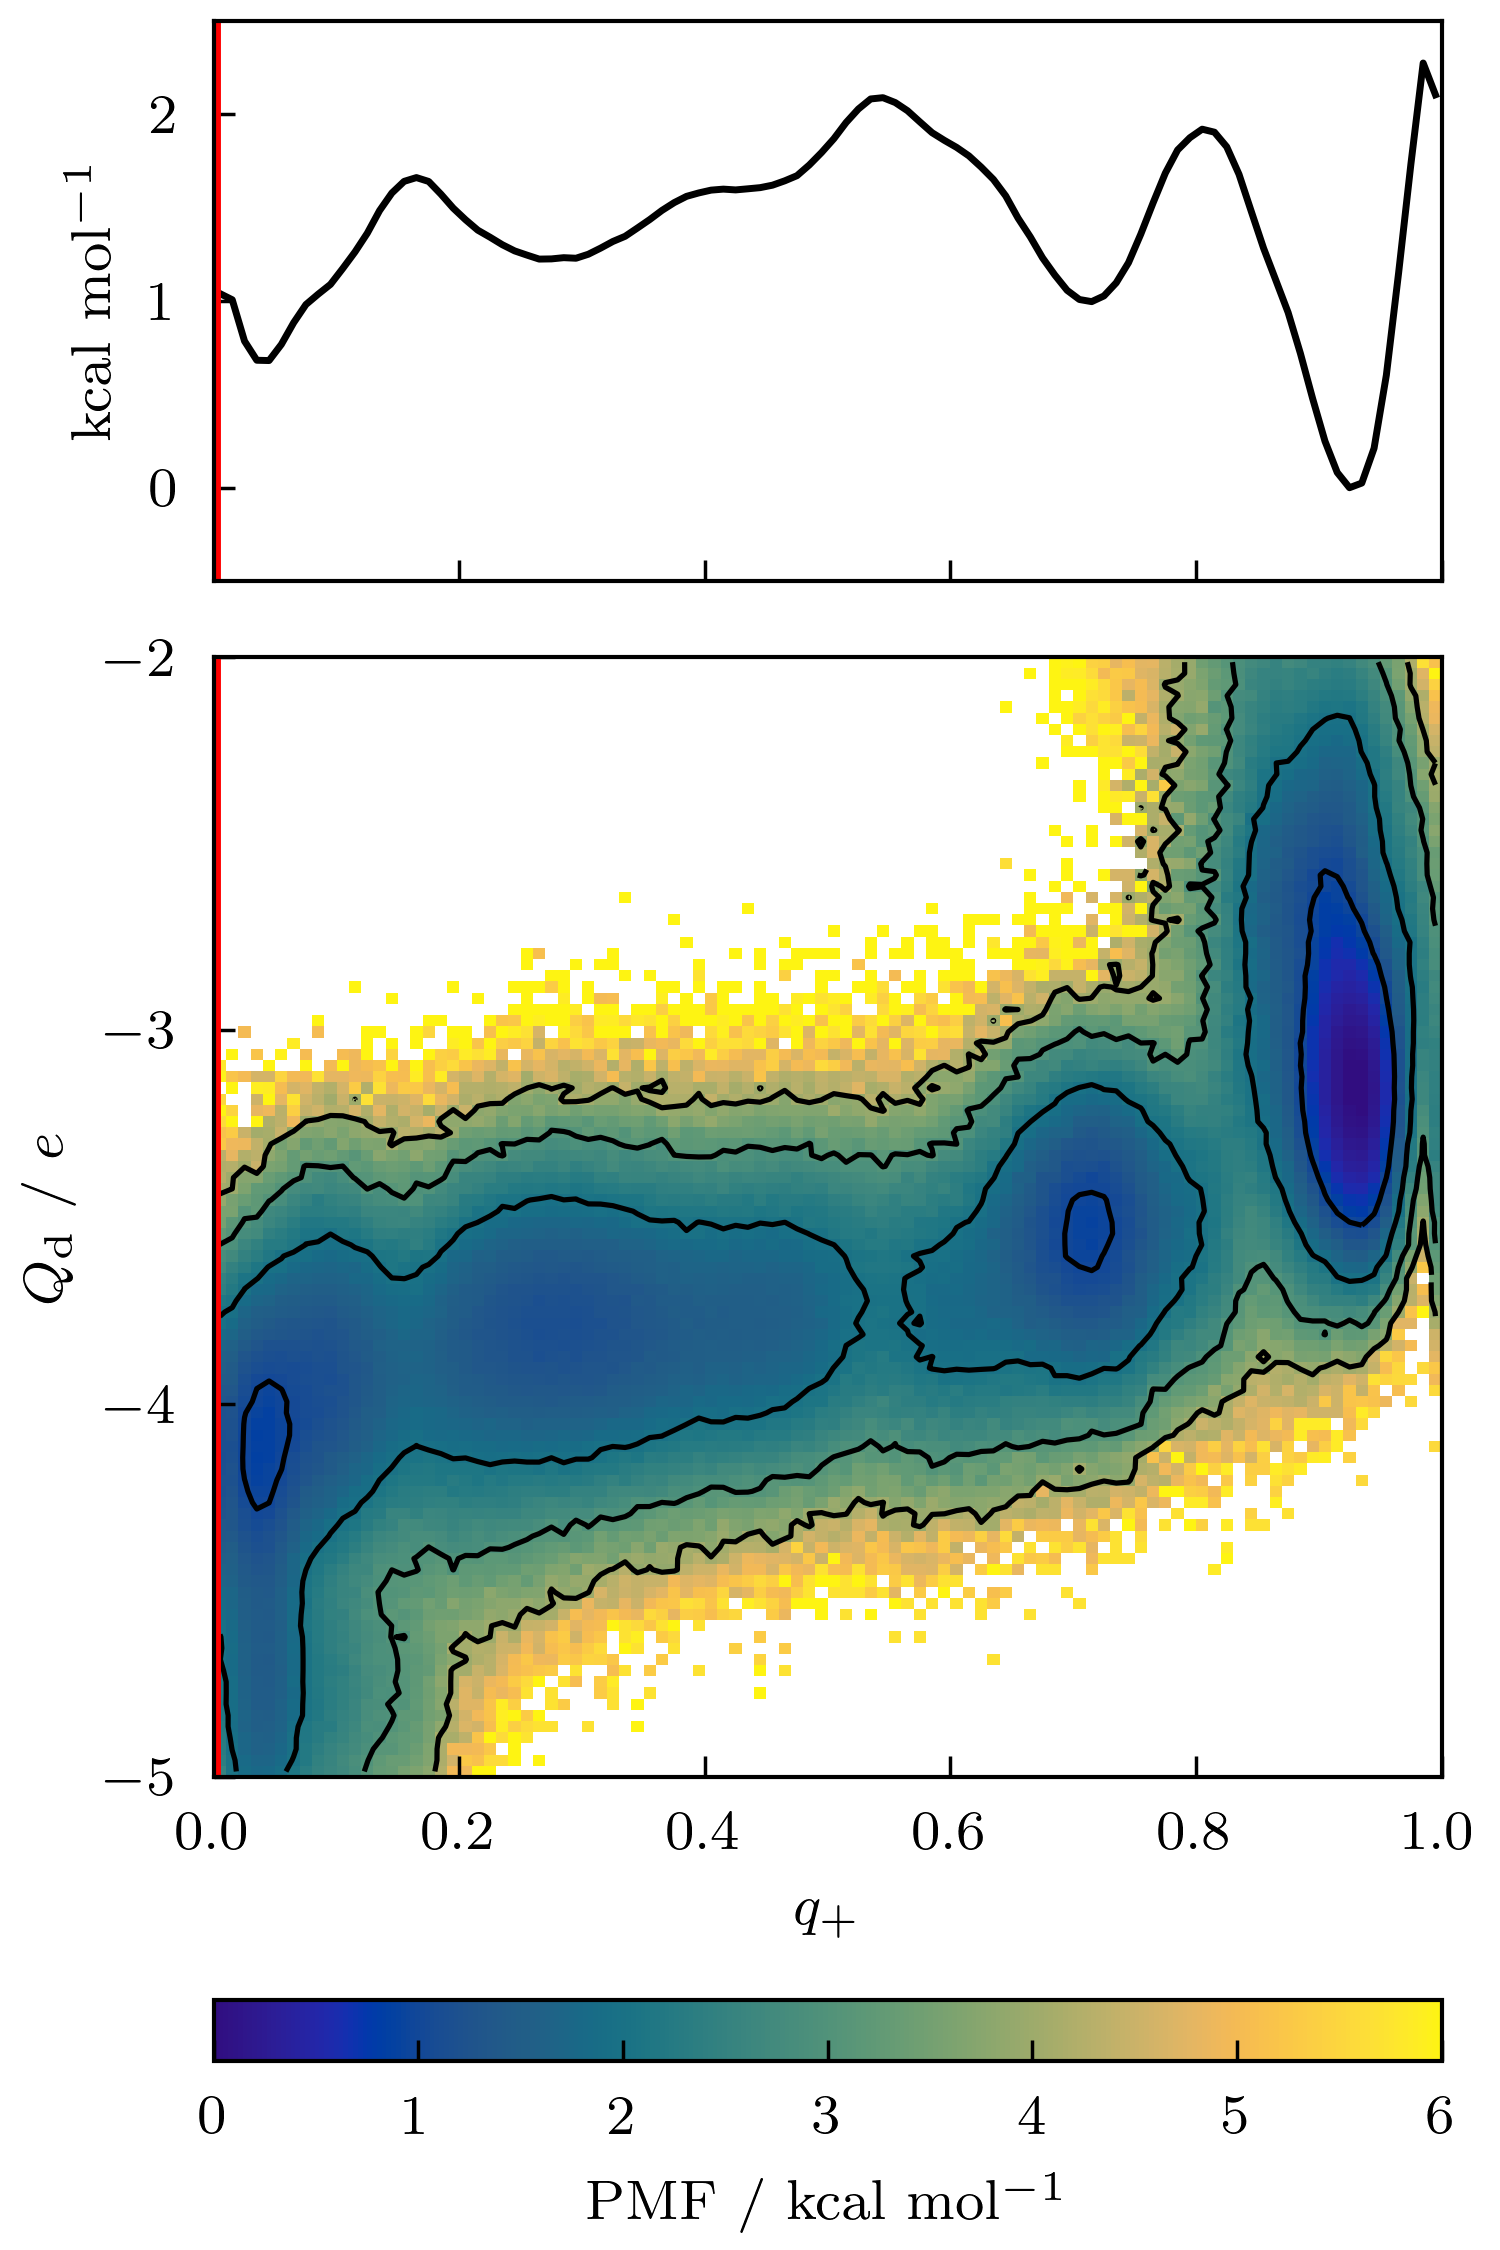

In [16]:
fig = plt.figure(figsize=(3., 4.5), dpi=500, constrained_layout=True)
gs = fig.add_gridspec(
    2,
    1,
    height_ratios=(1, 2),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    hspace=0.05,
)
ax = fig.add_subplot(gs[1])
ax_histx = fig.add_subplot(gs[0], sharex=ax)

lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lo, hi = -5.0, -2
dqe = np.linspace(lo, hi, 101)
dqc = (dqe[1:] + dqe[:-1]) / 2

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

w_delay = [w[:-lag] for w in weights]
qp_delay = [t[lag:] for t in qp_du]
dq_delay = [t[lag:] for t in dq_trajs]
pmf = extq.projection.density2d(qp_delay, dq_delay, w_delay, qe, dqe)
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf) - min_energy

pc0 = ax.pcolormesh(qe, dqe, diff.T * 0.593, cmap="macaw", vmin=0, vmax=6, rasterized=True)
ax.contour(qc, dqc, diff.T * 0.593, levels=np.arange(5), colors='black')
plt.colorbar(pc0, ax=ax, location="bottom", label="PMF / kcal mol$^{-1}$")
# ax.axhline(down_avg, ls="--", color="black")
# ax.axhline(up_avg, ls="-.", color="black")
ax.set_ylabel("$Q_{\\rm d}$ / $e$")
ax.set_xlabel("$q_+$")
ax.set_yticks(np.arange(-5, -1.5, 1))

with mpl.rc_context({"lines.linewidth": 1.0}):
    ax_histx.plot(qc, q_pmf * 0.593, color="black")
ax_histx.set_ylim([-0.5, 2.5])
ax_histx.set_ylabel("kcal mol$^{-1}$")
ax_histx.label_outer()

vertline = ax.axvline(0.0, color="red", lw=2)
vertline2 = ax_histx.axvline(0.0, color='red', lw=2)

def animate(i):
    vertline.set_xdata(0.025 * i)
    vertline2.set_xdata(0.025 * i)
    return (vertline, vertline2)

total_len = 7.6
# ani = animation.FuncAnimation(fig, animate, frames=40, interval=total_len/40, blit=True, save_count=50)
# ani.save("../../fig/paper/pmf_animate.gif", writer='imagemagick')
# plt.show()

In [10]:
%matplotlib widget

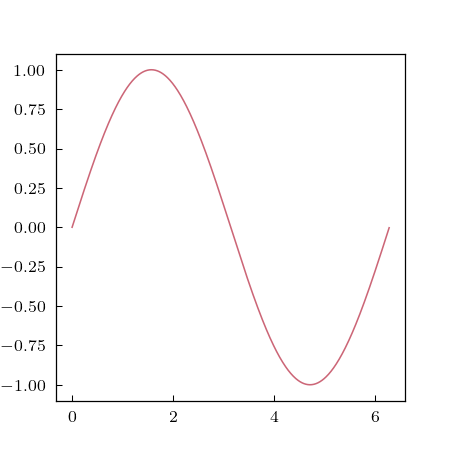

In [12]:
fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# HTML(ani.to_jshtml())

plt.show()